In [1]:
import sys
sys.path.append("./rnn-cnn/py_files/")

In [87]:
import torch
import torch.utils.data as data
import os
import time
import pickle
import operator
import numpy as np
import nltk
from PIL import Image
# from build_vocab import Vocabulary
import json
import shutil
import utils
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import utils
import spacy    
import itertools
import collections
cuda = torch.cuda.is_available()
cuda

False

#### Fetch Data

In [3]:
nlp = spacy.load('en_core_web_lg')

In [42]:
im_path_arch = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset_/dataset/arch_thumbs/big"
im_path_des = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset_/dataset/des_thumbs/big"
im_path_tech = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset_/dataset/tech_thumbs/big"

tagged_path_arch = "./dataset_/dataset/json_files/architecture_dz-cleaned-tagged.json"
tagged_path_des = "./dataset_/dataset/json_files/design_dz-cleaned-tagged.json"
tagged_path_tech = "./dataset_/dataset/json_files/technology_dz-cleaned-tagged.json"

vocab_path_arch = "../data/architecture_dz-cleaned.json"
vocab_path_des = "../data/design_dz-cleaned.json"
vocab_path_tech = "../data/technology_dz-cleaned.json"

im_paths = [im_path_arch, im_path_des, im_path_tech]
paths_for_vocab = [vocab_path_arch, vocab_path_des, vocab_path_tech]
tagged_files_paths = [tagged_path_arch, tagged_path_des, tagged_path_tech]
im_toy = [im_path_tech]
tagg_toy = [tagged_path_tech]

dataset_new_folder = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset_/dataset/all_tagged_images"
vocab_dict_path = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/data/vocab/vocab-dict.json"
vocab_res_dict_path = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/data/vocab/vocab-res-dict.json"

In [5]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self, nlp):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.nlp = nlp

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)
    
    
    def get_adj_from_sentence(self, sentence):
        """
        Parses sentence and get a list of cleaned lemmatized adj longer than 1 character. No duplicates
        """
        doc = self.nlp(sentence)
        adj = []
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_ = token.lemma_.lower()
                if len(adj_) > 1:
                    adj.append(adj_)
#         print("adj: ", adj)
        return list(set(adj))
        
    def get_adj_from_all_sentences(self, sentences):
        """
        Calls the function get_adj_from_sentence a sentences number of times
        """
        adj = []
        for sentence in sentences:
#             print("sentence: ", sentence)
            sent_adj = self.get_adj_from_sentence(sentence)
            adj.extend(sent_adj)
        return adj

In [6]:
def build_vocabulary(path, save_dict_path, nlp):
    """
    Builds vocabulary with the entirity of the datasets
    """
    
    # Create Utils instance
    U = utils.Utils()
    data_raw = U.jsons_to_list(path)
    
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary(nlp)
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>') 

    all_adjs = []
    for f, file in enumerate(data_raw): # 0_arch 1_des 2_...
        print("Starting building vocab corresponding to file: \n", f)
        for i in range(len(file)): # 900 samples
            sample_dict = file[i]                             
            sample_text = sample_dict['text'] # this is a list with strings
            adj_list = vocab.get_adj_from_all_sentences(sample_text)
            all_adjs.append(adj_list)
        print("....Finishing vocab file: \n", f)

    for sublist in all_adjs:
        for adj in sublist:
            vocab.add_word(adj)
            
    # Save vocab in dict 
    with open(vocab_dict_path, 'wb') as f:
        pickle.dump(vocab, f)
    f.close()
    return vocab

In [7]:
def load_vocab(file_path):
    
    # open file
    f = open(file_path, 'rb')
    
    # dump info to that file
    data = pickle.load(f)
    
    # close file
    f.close()
    
    # return vocab
    return data

In [43]:
VOCAB_restricted = build_vocabulary(tagged_files_paths, vocab_res_dict_path, nlp)

Utils object created...
Json_file: 0, length: 902, type: <class 'list'>
Json_file: 1, length: 888, type: <class 'list'>
Json_file: 2, length: 166, type: <class 'list'>
Starting building vocab corresponding to file: 
 0
....Finishing vocab file: 
 0
Starting building vocab corresponding to file: 
 1
....Finishing vocab file: 
 1
Starting building vocab corresponding to file: 
 2
....Finishing vocab file: 
 2


In [44]:
len(VOCAB_restricted)

2803

In [8]:
VOCAB = load_vocab(vocab_dict_path)

In [9]:
len(VOCAB)

7264

In [10]:
# VOCAB = build_vocabulary(paths_for_vocab, vocab_dict_path, nlp)
# print("len of VOCAB: ", len(VOCAB))

In [81]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
NUMBERS = '0123456789'

class PreprocessedData(object):
    def __init__(self, files_paths, images_paths, new_folder, nlp, vocab):
        """
        train_file_path = list with files
        test_file_path = list with files
        """
        
        # Create pipe
        self.nlp = nlp
        
        # Inherit vocabulary
        self.VOCAB = vocab
        
        # Call to utils
        self.Utils = utils.Utils()
        
        # paths to jsons
        self.files_paths = files_paths
        
        # path to image folders
        self.images_paths = images_paths

        # path to new image_path
        self.new_image_path = new_folder
        
        # Dataset
        self.train_data = None 
        self.dev_data = None
        self.train_labels = None
        self.dev_labels = None
        
        # Run
        print("\nRunner....")
        self.runner()
        
    ############## PROCESSING DATA ##############
    def get_adj_from_sentence(self, sentence):
        """
        Parses sentence and get a list of cleaned lemmatized adj longer than 1 character. No duplicates
        """
        doc = self.nlp(sentence)
        adj = []
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_ = token.lemma_.lower()
                if len(adj_) > 1:
                    adj.append(adj_)
        return list(set(adj))
        
    def get_adj_from_all_sentences(self, sentences):
        """
        Calls the function get_adj_from_sentence a sentences number of times
        """
        adj = []
        for sentence in sentences:
            sent_adj = self.get_adj_from_sentence(sentence)
            adj.extend(sent_adj)
        return adj
        
    def is_valid(self, images, adj):
        """
        Avoids empty data samples
        """
        if adj == []: return False
        if images == []: return False
        return True
    
    
    def handle_N_labels(self, list_of_labels, N_labels):
        """
        Truncates or pads list of labels according to N_labels
        """
        pad_with = list_of_labels[0]
        if len(list_of_labels) == N_labels:
            return list_of_labels
        
        elif len(list_of_labels) < N_labels:
            diff = N_labels - len(list_of_labels)
            for i in range(diff):
                list_of_labels.append(pad_with)
        else:
            list_of_labels = list_of_labels[:N_labels]
        
        return list_of_labels
    
    def get_images_labels(self, files):
        """
        Parse json files and outputs train_data (image) + numpy array labels for multi-label classification
        """
        train_data = []
        labels = dict()
        
        for f, file in enumerate(files): # 0_arch 1_des 2_tech
            im_per_section = []     # these ones have the same length
            for i in range(len(file)): # 902 samples architecture, 675 samples design  
                sample_dict = file[i]                  # dictionary
                sample_text = sample_dict['text']      # list with sentences (strings)
                text_tags = sample_dict['text-tags']
                sample_images = sample_dict['images']
                image_tags = sample_dict['image-tags']
                  
                # 2) Select valid text
                tagged_text = [sample_text[ALPHABET.index(letter)].lower() for letter in text_tags]
                
                # 3) Get adjectives from valid text
                adj = self.get_adj_from_all_sentences(tagged_text)
                
                # 4) Select valid images
                tagged_images = [sample_images[int(letter)] for letter in image_tags]
                
                if self.is_valid(tagged_images, adj):
                    # Add special token '<end>' as a label
#                     adj.append('<end>')
                    adj = self.handle_N_labels(adj, 1)
                    for image in tagged_images:
                        labels[image[5:]] = adj[0]
                    im_per_section.append(tagged_images)
            
            train_data.append(im_per_section)

        return train_data, labels
                    
    def convert_labels_to_int(self, labels):
        """
        Convert labels to int array
        """
        labels_int = dict()
        for key, val in labels.items():
            label_array = np.zeros(len(val), dtype = int)
            for i, label in enumerate(val):
                # Try add label in vocabulary. If already exists, nothing happens, just get the idx
                self.VOCAB.add_word(label)
                idx = self.VOCAB.word2idx[label]
                label_array[i] = idx
            labels_int[key] = label_array
        
        return labels_int
    
    def copy_wrapper(self, list_dataset_per_section, curr_folders, dest_folder):
        self.all_failed_samples = []
        for i, dataset in enumerate(list_dataset_per_section):
            self.all_failed_samples.append(self.copy_dataset(dataset, curr_folders[i], dest_folder))
        
    def copy_dataset(self, image_dataset, curr_folder, dest_folder):
        fail_samples = self.Utils.copy_files(image_dataset, curr_folder, dest_folder)
        return fail_samples
    
    def flatten(self, S):
        if S == []:
            return S
        if isinstance(S[0], list):
            return self.flatten(S[0]) + self.flatten(S[1:])
        return S[:1] + self.flatten(S[1:])
    
    def change_name(self, dataset):
        dataset = self.flatten(dataset)
        for i, image in enumerate(dataset):
            newname = image[5:]
            dataset[i] = newname
        return dataset
            
    def remove_dups(self, l):
        seen = []
        dups = []
        for sample in l:
            if sample not in seen:
                seen.append(sample)
            else:
                dups.append(sample)
        
        for dup in dups:
            if dup in l:
                l.remove(dup)
        return l
    
    def remove_dups_labels(self, x):
        seen = []
        dups = []
        for key,val in x.items():
            if key not in seen:
                seen.append(key)
            else:
                dups.append(key)
        
        for dup in dups:
            if dup in x.keys():
                del x[dup]
    
    def flip_dictionary(self, dic):
        """
        Flips dictionary of labels. From key=image_name, val=adj --> key=adj, val=list of images
        """
        flipped = {}
        for k,val_list in dic.items():
            for v in val_list:
                if v not in flipped:
                    flipped[v] = [k]
                else:
                    flipped[v].append(k)
        return flipped
    
    def split_train_val(self, dic, percentage):
        val_set = {}
        train_set = {}

        for k, v in dic.items():
            if len(v) > 3:
                keep = int(len(v)*percentage) #for train_set
                train_set[k] = v[:keep]
                val_set[k] = v[keep:]
            else:
                train_set[k] = v
        
        return train_set, val_set
    
    def partition_data(self, percentage):
                
        # Flipped current dict
        flipped = self.flip_dictionary(self.labels)
        
        # Split dictionary into train and validation set 
        inv_train_set, inv_val_set = self.split_train_val(flipped, percentage)
        
        # Flip it back
        self.label_train = self.flip_dictionary(inv_train_set)
        self.label_val = self.flip_dictionary(inv_val_set)
        
        # Store all images_names in corresponding folders
        
        self.train_d = []
        self.val_d   = []
        for i in range(len(self.train_data)):
            image_name = self.train_data[i]
            if image_name in self.label_train.keys():
                self.train_d.append(image_name)
            else:
                self.val_d.append(image_name)

    def runner(self):
        files = self.Utils.jsons_to_list(self.files_paths)    
        self.train_data, self.labels = self.get_images_labels(files) # keep track of the length of these variables
        
        # This puts all the images in one folder. 
#         self.copy_wrapper(self.train_data, self.images_paths, self.new_image_path)
        
        # Change names of self.train
        self.train_data = self.change_name(self.train_data)
        
        # Partition data
        self.partition_data(0.7)
        
        print("before removing dups: ", len(self.label_train), len(self.label_val))
        # remove dups in labels
        self.remove_dups_labels(self.label_train)
        self.remove_dups_labels(self.label_val)
        print("after removing dups: ", len(self.label_train), len(self.label_val))
        # This needs to be done after flattening
        self.label_train_int = self.convert_labels_to_int(self.label_train)
        self.label_val_int = self.convert_labels_to_int(self.label_val)
        
        # Removes potential duplicates
        self.remove_dups(self.train_d)
        self.remove_dups(self.val_d)


In [82]:
dataset = PreprocessedData(tagged_files_paths, im_paths, dataset_new_folder, nlp, VOCAB_restricted)

Utils object created...

Runner....
Json_file: 0, length: 902, type: <class 'list'>
Json_file: 1, length: 888, type: <class 'list'>
Json_file: 2, length: 166, type: <class 'list'>
before removing dups:  3635 1640
after removing dups:  3635 1640


In [85]:
# dataset = PreprocessedData(tagg_toy, im_toy, dataset_new_folder, nlp, VOCAB)
dataset.labels

{'3c0a85006109b91ec636dbf68b1f9237abdc32ca.jpg': 'generous',
 'd927842dfd2c67d0ef2fdc624427a58f0d3c9434.jpg': 'generous',
 '77768d2fcb5367b4786813059029a7e886a13dde.jpg': 'generous',
 '9ab9a4a8979dd6485f7d6b32a44f127bbefc3d2c.jpg': 'generous',
 '0b4d700507c75a79ca30e970ade1da8702da3d6c.jpg': 'generous',
 '50abf90ec81f2bb1e8a8faac1d2fa52a7928991f.jpg': 'generous',
 '40d561c04f4a8b9564e53201d85a13dd1092f239.jpg': 'generous',
 'a7d6c07e6cb3930096ebda922fff72f5d392ea2b.jpg': 'generous',
 'ab76c255ebdc2c6b78f2ab2aabaa136a31bf167b.jpg': 'generous',
 '2ecd7c1f54861ec8cfee73c6b6caca23418137a5.jpg': 'generous',
 '815f25e4dde8d59a7176f2757d3186b4430662b0.jpg': 'same',
 '3f634e1e52d66850d223f5e0f2ab6892c08a6a92.jpg': 'same',
 '611351c3e7ca232f7d09e47689aa6b9f7e30d9a6.jpg': 'same',
 'cff69897771b1c0f789584c20f62e9e894ba44d9.jpg': 'same',
 'f310240236f16bf8c4eb96e6c7b028622f557fd7.jpg': 'same',
 'd91e308038480e85f38d0f7a5df11fe61f3afc3e.jpg': 'same',
 '0a719bbaa737fdf82c621556b496b85be4244515.jpg':

In [95]:
from itertools import islice

In [96]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [98]:
count_labels = collections.Counter(dataset.labels.values())
sorted_count = sorted(count_labels.items(), key=operator.itemgetter(1), reverse=True)
sc100 = take(7, sorted_count)
sorted_count
sc100

[('natural', 95),
 ('new', 60),
 ('more', 57),
 ('iconic', 56),
 ('long', 55),
 ('different', 55),
 ('large', 52)]

In [49]:
len(dataset.label_train), len(dataset.label_val)

(3276, 1631)

In [50]:
len(dataset.train_d), len(dataset.val_d)

(3276, 1631)

In [51]:
dataset.label_train

{'3c0a85006109b91ec636dbf68b1f9237abdc32ca.jpg': ['generous'],
 'd927842dfd2c67d0ef2fdc624427a58f0d3c9434.jpg': ['generous'],
 '77768d2fcb5367b4786813059029a7e886a13dde.jpg': ['generous'],
 '9ab9a4a8979dd6485f7d6b32a44f127bbefc3d2c.jpg': ['generous'],
 '0b4d700507c75a79ca30e970ade1da8702da3d6c.jpg': ['generous'],
 '50abf90ec81f2bb1e8a8faac1d2fa52a7928991f.jpg': ['generous'],
 '40d561c04f4a8b9564e53201d85a13dd1092f239.jpg': ['generous'],
 '815f25e4dde8d59a7176f2757d3186b4430662b0.jpg': ['same'],
 '3f634e1e52d66850d223f5e0f2ab6892c08a6a92.jpg': ['same'],
 '611351c3e7ca232f7d09e47689aa6b9f7e30d9a6.jpg': ['same'],
 'cff69897771b1c0f789584c20f62e9e894ba44d9.jpg': ['same'],
 'f310240236f16bf8c4eb96e6c7b028622f557fd7.jpg': ['same'],
 'd91e308038480e85f38d0f7a5df11fe61f3afc3e.jpg': ['same'],
 '1ea421430a14bb6dd15b5d6b2e981939c8d676e8.jpg': ['same'],
 '0c089f47b61e1de7de7a5f804875dcaf423acd5f.jpg': ['same'],
 '5711facd29306a56c4037cd22384c46a556ca931.jpg': ['same'],
 '65f1ca3fb0ac7cd8b2ff78fd70

In [52]:
dataset.label_val

{'a7d6c07e6cb3930096ebda922fff72f5d392ea2b.jpg': ['generous'],
 'ab76c255ebdc2c6b78f2ab2aabaa136a31bf167b.jpg': ['generous'],
 '2ecd7c1f54861ec8cfee73c6b6caca23418137a5.jpg': ['generous'],
 '91b983e069cb87bc81362de8f4226ad715155fa7.jpg': ['same'],
 '0d3063842486abcd22ee24c5e34406980b565bd6.jpg': ['same'],
 'c02227c44591ec61f81d7f50babb4e0a9442401a.jpg': ['same'],
 'edaffdff9ab06744cb88305a8d08c3b1516119c7.jpg': ['same'],
 'c3c1c7a41e7de731f36b7aab27af8300051fd9a6.jpg': ['same'],
 '8af0452685e683d8e552b342553b4e8825a3ec55.jpg': ['same'],
 'dd8b562d10441b2b0178d733e55994a9642d3925.jpg': ['same'],
 '16f56289e9cdeac1b772ccd9b768c8abc5e23c54.jpg': ['same'],
 '375ed11ae0b82c780d92525c06cf95e3af2b49f7.jpg': ['same'],
 'e717301eb4106e869c6ab2b4a5faec58a3befd34.jpg': ['same'],
 'f689f6908a93593f38796bd860cb2ad65486cd75.jpg': ['same'],
 '52e99a125659679739763776db3c4d39232d673c.jpg': ['same'],
 '317a1555f74ee60522d663487dd0596f220bdffe.jpg': ['connected'],
 'e68393e9a405e6af0038e456cdf9d06fab6dd

In [17]:
def see_images(N):
    # Read using Pillow
    for i in range(N):
        name = dataset_new_folder + "/" + dataset.train_data[i+100]
        image = np.array(Image.open(name))
        print(image.shape)
        plt.imshow(image)
        plt.show()

(85, 128, 3)


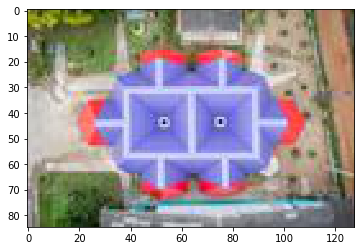

(85, 128, 3)


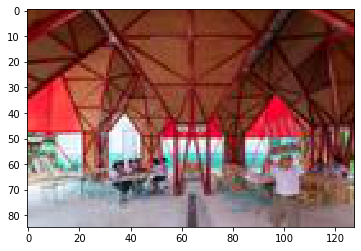

(85, 128, 3)


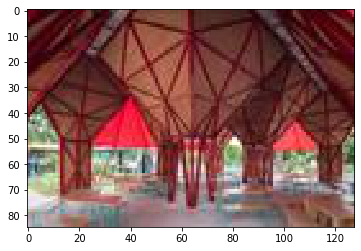

In [18]:
see_images(3)

In [53]:
class ImageDataset(Dataset):
    def __init__(self, dataset, train=True):
        self.data = dataset
        if train:
            self.image_labels_string = dataset.label_train    # dictionary
            self.image_labels_int = dataset.label_train_int
            self.image_names = dataset.train_d  # list with image_names
        
        else:
            self.image_labels_string = dataset.label_val    # dictionary
            self.image_labels_int = dataset.label_val_int
            self.image_names = dataset.val_d  # list with image_names

        self.name2idx()
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.idx2name[index]
        name = dataset_new_folder + "/" + self.image_names[index]
        img = Image.open(name)
        
        img = transforms.Compose([
        transforms.Resize((64, 64)),
#         transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])(img)
        
        label = torch.from_numpy(self.image_labels_int[image_name])
        return img, label
    
    def name2idx(self):
        self.name2idx = dict()
        self.idx2name = dict()
        for i, key in enumerate(self.image_labels_string.keys()):
            self.name2idx[key] = i
            self.idx2name[i] = key
            
def collate(sequence):
    """
    "the input of this function is the output of function __getitem__"
    "this gets BATCH_SIZE times GETITEM! "
    if batch_Size == 2 --> sequence is a list with length 2. 
    Each list is a tuple (image, label) = ((3,64,64), label_length)
    """

    # Concatenate all images in the batch
    inputs = torch.cat(([  batch_[0].view(-1, 3, 64, 64) for batch_ in sequence]), dim=0)
    
    # Pad labels with max_sequence_label
    targets  = torch.LongTensor([batch_[1] for batch_ in sequence])# batch_first=True)
#     targets_length  = torch.LongTensor([len(batch_[1]) for batch_ in sequence])     
    
#     print("\nInputs: {}\nTargets: {}\nTargets length:{}\n".format(len(inputs), targets.shape, targets_length))
    return inputs, targets


In [54]:
dataset_train = ImageDataset(dataset, train=True)

In [55]:
dataset_val = ImageDataset(dataset, train=False)

In [56]:
len(dataset_train), len(dataset_val)

(3276, 1631)

In [57]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [58]:
class DECODER(nn.Module):
    """
    The only combination I get to work is using the output of the LSTM, not the hiddens. 
    Can be either 1 direction or 2.
    
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, mlp_list):
        super(DECODER, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.mlp_list = mlp_list
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        layers = []
        for i in range(len(mlp_list)-1):
            layers.append(nn.Linear(mlp_list[i], mlp_list[i+1])) 
            layers.append(nn.BatchNorm1d(mlp_list[i+1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(mlp_list[-1], output_dim))
        layers.append(nn.BatchNorm1d(output_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.net = nn.Sequential(*layers)
        
    def forward(self, image_feature, labels):        
        res = self.net(image_feature)
        return res

    def sample(self, feature):
        encoder.eval()
        decoder.eval()
        output = self.net(feature)                # outputs:  (batch_size, vocab_size)
        max_index = output.max(dim = 1).indices                   # predicted: (batch_size)
        return max_index
    
    


In [59]:
batch_size = 32
num_workers = 8 if cuda else 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, collate_fn = collate, shuffle=True, num_workers=num_workers, drop_last=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, collate_fn = collate,shuffle=False, num_workers=num_workers, drop_last=True)


In [ ]:
for d in train_dataloader:
    print(d[1], d[1].shape)
    break

In [68]:
## DIMENSIONS ###
embedding_dim = 64
num_hidden_nodes = 512
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)

size_of_vocab = len(dataset.VOCAB)
num_output_nodes = size_of_vocab

num_layers = 3
bidirection = True
dropout = 0
nepochs = 20
lr = 0.001
weight_decay = 0.00001
mlp_list = [64, 512, 1024, 1024, 2048, 2048, 2048]

# Instantiate
encoder = EncoderCNN(embedding_dim)
decoder = DECODER(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, mlp_list)

# Criterion & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(decoder.parameters(), lr=lr, weight_decay=weight_decay)

size_of_vocab

cpu


2803

In [ ]:
import pdb

In [62]:
def label_accuracy(outs, target):
#     print("target shape, ", target.shape)
    max_index = outs.max(dim = 1).indices
#     target_index = target.max(dim=1).indices
    num_correct = (max_index == target).sum().item()
    return num_correct / target.shape[0]

In [63]:
def train(loader, encoder, decoder, criterion, optimizer, epoch, num_epochs):
    # Place model into mode and onto correct device
    decoder.train()
    decoder.to(device=DEVICE)

    running_loss = 0.0
    running_acc = 0.0
    total_step = len(loader)
    for i, (images, captions) in enumerate(loader):
        # Zero gradients
        optimizer.zero_grad()
        
        images = images.to(device)
        captions = captions.to(device) # --> they come padded, so we need to pack it to get an array of labels  

        # Econde image with CNN
#         print("images: ", images.shape)
        features = encoder(images)
        
        # Get model outputs
        outputs = decoder(features, captions) # <---- main function of the whole training
        
        # Calculate loss & accuracy
        loss = criterion(outputs, captions)
        decoder.zero_grad()
        encoder.zero_grad()      
        
        # Calculate loss & accuracy
        running_loss += loss.item()

        accuracy = label_accuracy(outputs, captions)
        running_acc += accuracy
        
        # Compute gradients and take step
        loss.backward()
        optimizer.step()
        
        # Print log info
        if i % 10 == 0 and i != 0:
            perplexity = np.exp(loss.item()/i)
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Accuracy: {:5.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item(), running_acc/(i+1))) 

    running_loss /= len(loader)
    running_acc /= len(loader)
    return running_loss, running_acc

In [64]:
def test(loader, encoder, decoder, criterion, epoch, num_epochs):
    with torch.no_grad():
        # Place into eval mode
        decoder.eval()
        decoder.to(device=DEVICE)
        encoder.eval()
        running_loss = 0.0
        running_acc = 0.0
        perplexity = 10000
        total_step = len(loader)
        for i, (images, captions) in enumerate(loader):

            images = images.to(device)
            captions = captions.to(device) # --> they come padded, so we need to pack it to get an array of labels  
            
            # Econde image with CNN
            
            features = encoder(images)
        
            # Get model outputs
            outputs = decoder(features, captions) # <---- main function of the whole training

            # Calculate loss & accuracy
            loss = criterion(outputs, captions)
            running_loss += loss.item()
            
            accuracy = label_accuracy(outputs, captions)
            running_acc += accuracy
            
            # Print log info
            if i % 40 == 0 and i != 0:
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Accuracy: {:5.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item(), running_acc/(i+1))) 
    
    running_loss /= len(loader)
    running_acc /= len(loader)

    return running_loss, running_acc

In [65]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):

    plt.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.show()
    
def make_graph_test_acc(epochs, test, val_name, name_long, name_short):

    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.show()
    

def run_epochs(encoder, decoder, optimizer, criterion, train_loader, dev_loader, n_epochs, run_id):
    train_losses, train_accs = [], []
    test_losses,  test_accs = [], []
    
    epochs = []
    
    for e in range(n_epochs):
        print('----- EPOCH ------- \n', e+1)
        
        # Train
        train_loss, train_acc = train(train_loader, encoder, decoder, criterion, optimizer, e, n_epochs)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Test
        test_loss, test_acc = test(dev_loader, encoder, decoder, criterion, e, n_epochs)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # Epochs
        epochs.append(e)
        if e % 4 == 0 and e != 0:
            
            print('Training Loss: ', train_loss)
            print('Training Accuracy: ', train_acc)
            print("Train losses:\n{}\nTest losses:\n{}\n".format(train_losses, test_losses))
        
        # Make graph after each epoch
        if e != 0:
            make_graph(epochs, train_accs, test_accs, 'Training Acc', 'Testing Acc',
                       'Training and Testing Accuracies', 'Accuracy')
            make_graph(epochs, train_losses, test_losses, 'Training loss', 'Testing loss',
                       'Training and Testing loss', 'Loss')
            make_graph_test_acc(epochs, test_accs, 'Testing Acc',
                       'Testing Accuracies', 'Accuracy')

        # save model
        model_path = os.path.join('experiments', run_id, 'model-{}.pkl'.format(e))
        torch.save({'state_dict': decoder.state_dict()},model_path)
#         torch.save(encoder.state_dict(), "./saved_models/encoder-{}.pth".format(e))
#         torch.save(decoder.state_dict(), "./saved_models/decoder-{}.pth".format(e))
    
    return train_losses, test_losses, train_accs, test_accs

# path_to_load = './saved_models/v3_7.pth'
# model.load_state_dict(torch.load(path_to_load, map_location=DEVICE))


In [66]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)


Saving models, predictions, and generated words to ./experiments/1588541641


----- EPOCH ------- 
 1
Epoch [1/20], Batch [10/102], Loss: 7.6741, Accuracy: 0.0000
Epoch [1/20], Batch [20/102], Loss: 7.9497, Accuracy: 0.0030
Epoch [1/20], Batch [30/102], Loss: 8.0028, Accuracy: 0.0020
Epoch [1/20], Batch [40/102], Loss: 7.9959, Accuracy: 0.0023
Epoch [1/20], Batch [50/102], Loss: 7.7990, Accuracy: 0.0049
Epoch [1/20], Batch [60/102], Loss: 7.6282, Accuracy: 0.0051
Epoch [1/20], Batch [70/102], Loss: 7.6855, Accuracy: 0.0053
Epoch [1/20], Batch [80/102], Loss: 7.5842, Accuracy: 0.0054
Epoch [1/20], Batch [90/102], Loss: 7.7667, Accuracy: 0.0062
Epoch [1/20], Batch [100/102], Loss: 7.4784, Accuracy: 0.0062
Epoch [1/20], Batch [40/50], Loss: 7.6971, Accuracy: 0.0061
----- EPOCH ------- 
 2
Epoch [2/20], Batch [10/102], Loss: 6.7820, Accuracy: 0.0625
Epoch [2/20], Batch [20/102], Loss: 6.8138, Accuracy: 0.0685
Epoch [2/20], Batch [30/102], Loss: 7.1240, Accuracy: 0.0645
Epoch [2/20], Batch [40/102], Loss: 6.3869, Accuracy: 0.0579
Epoch [2/20], Batch [50/102], Loss: 6

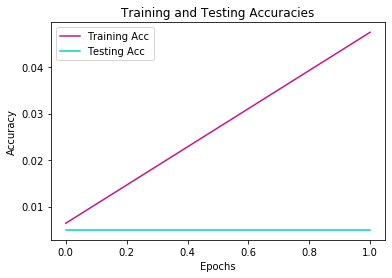

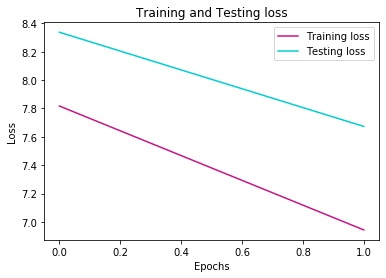

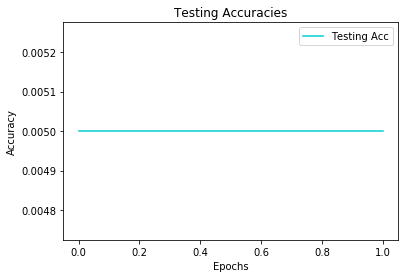

----- EPOCH ------- 
 3
Epoch [3/20], Batch [10/102], Loss: 5.8072, Accuracy: 0.2102
Epoch [3/20], Batch [20/102], Loss: 5.8675, Accuracy: 0.2083
Epoch [3/20], Batch [30/102], Loss: 5.6155, Accuracy: 0.2137
Epoch [3/20], Batch [40/102], Loss: 5.5334, Accuracy: 0.2119
Epoch [3/20], Batch [50/102], Loss: 5.9121, Accuracy: 0.2040
Epoch [3/20], Batch [60/102], Loss: 5.8892, Accuracy: 0.1942
Epoch [3/20], Batch [70/102], Loss: 6.1388, Accuracy: 0.1849
Epoch [3/20], Batch [80/102], Loss: 6.3917, Accuracy: 0.1752
Epoch [3/20], Batch [90/102], Loss: 5.9501, Accuracy: 0.1652
Epoch [3/20], Batch [100/102], Loss: 6.3319, Accuracy: 0.1569
Epoch [3/20], Batch [40/50], Loss: 7.7839, Accuracy: 0.0030


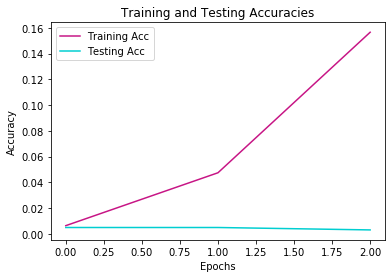

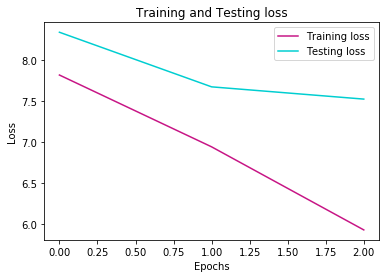

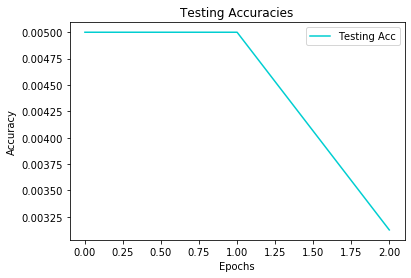

----- EPOCH ------- 
 4
Epoch [4/20], Batch [10/102], Loss: 5.2089, Accuracy: 0.4176
Epoch [4/20], Batch [20/102], Loss: 5.4246, Accuracy: 0.3735
Epoch [4/20], Batch [30/102], Loss: 5.0706, Accuracy: 0.3720
Epoch [4/20], Batch [40/102], Loss: 5.1998, Accuracy: 0.3529
Epoch [4/20], Batch [50/102], Loss: 5.2317, Accuracy: 0.3462
Epoch [4/20], Batch [60/102], Loss: 5.2168, Accuracy: 0.3304
Epoch [4/20], Batch [70/102], Loss: 5.0917, Accuracy: 0.3222
Epoch [4/20], Batch [80/102], Loss: 5.5159, Accuracy: 0.3164
Epoch [4/20], Batch [90/102], Loss: 5.3620, Accuracy: 0.3032
Epoch [4/20], Batch [100/102], Loss: 5.4506, Accuracy: 0.2961
Epoch [4/20], Batch [40/50], Loss: 7.6375, Accuracy: 0.0061


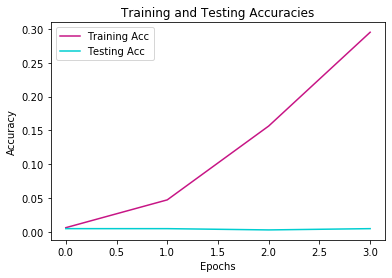

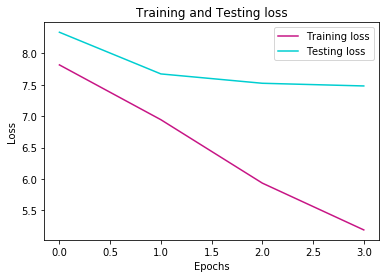

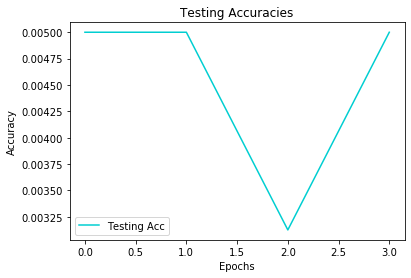

----- EPOCH ------- 
 5
Epoch [5/20], Batch [10/102], Loss: 4.2618, Accuracy: 0.5852
Epoch [5/20], Batch [20/102], Loss: 4.2725, Accuracy: 0.5387
Epoch [5/20], Batch [30/102], Loss: 4.7768, Accuracy: 0.5050
Epoch [5/20], Batch [40/102], Loss: 4.5770, Accuracy: 0.5015
Epoch [5/20], Batch [50/102], Loss: 4.6216, Accuracy: 0.4853
Epoch [5/20], Batch [60/102], Loss: 4.3167, Accuracy: 0.4800
Epoch [5/20], Batch [70/102], Loss: 4.5480, Accuracy: 0.4639
Epoch [5/20], Batch [80/102], Loss: 4.5123, Accuracy: 0.4541
Epoch [5/20], Batch [90/102], Loss: 4.5774, Accuracy: 0.4433
Epoch [5/20], Batch [100/102], Loss: 4.5604, Accuracy: 0.4276
Epoch [5/20], Batch [40/50], Loss: 8.1872, Accuracy: 0.0053
Training Loss:  4.530749536028095
Training Accuracy:  0.4264705882352941
Train losses:
[7.816964560864019, 6.943717133765127, 5.933524309420118, 5.188007331361957, 4.530749536028095]
Test losses:
[8.337122564315797, 7.673172969818115, 7.524220628738403, 7.481536464691162, 7.707434740066528]



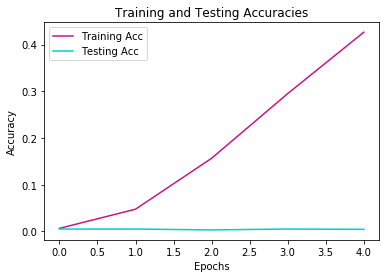

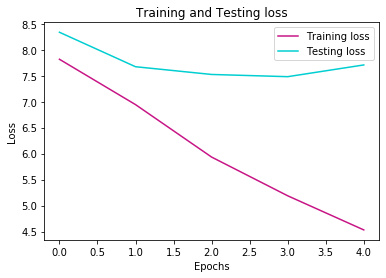

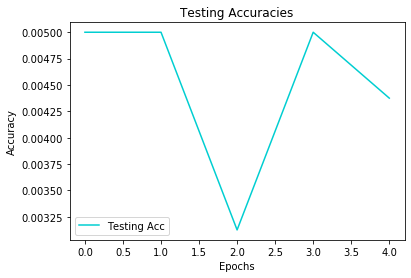

----- EPOCH ------- 
 6
Epoch [6/20], Batch [10/102], Loss: 4.0695, Accuracy: 0.6506
Epoch [6/20], Batch [20/102], Loss: 3.7089, Accuracy: 0.6726
Epoch [6/20], Batch [30/102], Loss: 4.2057, Accuracy: 0.6502
Epoch [6/20], Batch [40/102], Loss: 4.3973, Accuracy: 0.6418
Epoch [6/20], Batch [50/102], Loss: 3.8651, Accuracy: 0.6348
Epoch [6/20], Batch [60/102], Loss: 3.7487, Accuracy: 0.6255
Epoch [6/20], Batch [70/102], Loss: 3.7367, Accuracy: 0.6140
Epoch [6/20], Batch [80/102], Loss: 4.0534, Accuracy: 0.5968
Epoch [6/20], Batch [90/102], Loss: 3.9683, Accuracy: 0.5821
Epoch [6/20], Batch [100/102], Loss: 4.0094, Accuracy: 0.5650
Epoch [6/20], Batch [40/50], Loss: 7.6371, Accuracy: 0.0030


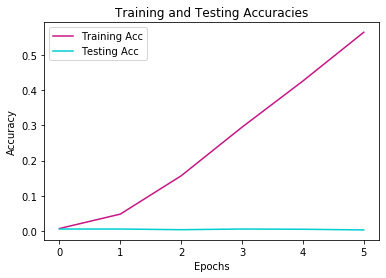

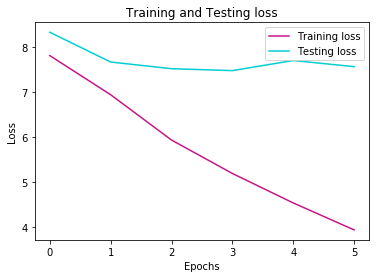

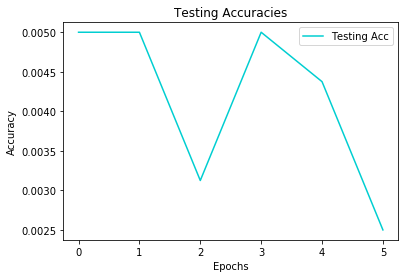

----- EPOCH ------- 
 7
Epoch [7/20], Batch [10/102], Loss: 3.1195, Accuracy: 0.6960
Epoch [7/20], Batch [20/102], Loss: 3.3752, Accuracy: 0.7113
Epoch [7/20], Batch [30/102], Loss: 3.1864, Accuracy: 0.7117
Epoch [7/20], Batch [40/102], Loss: 3.4149, Accuracy: 0.6974
Epoch [7/20], Batch [50/102], Loss: 3.4008, Accuracy: 0.7016
Epoch [7/20], Batch [60/102], Loss: 3.4184, Accuracy: 0.6998
Epoch [7/20], Batch [70/102], Loss: 3.2682, Accuracy: 0.6910
Epoch [7/20], Batch [80/102], Loss: 3.5067, Accuracy: 0.6809
Epoch [7/20], Batch [90/102], Loss: 3.7098, Accuracy: 0.6748
Epoch [7/20], Batch [100/102], Loss: 3.7627, Accuracy: 0.6634
Epoch [7/20], Batch [40/50], Loss: 7.6806, Accuracy: 0.0053


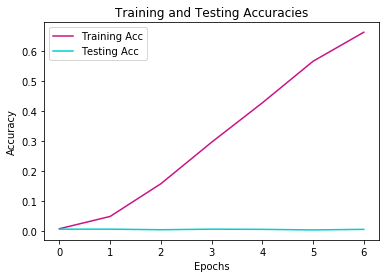

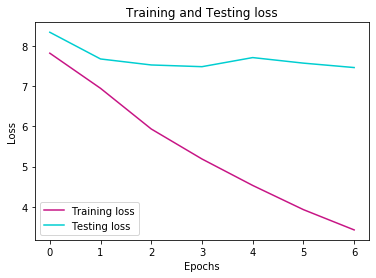

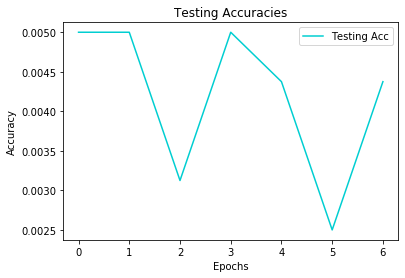

----- EPOCH ------- 
 8
Epoch [8/20], Batch [10/102], Loss: 2.9588, Accuracy: 0.7784
Epoch [8/20], Batch [20/102], Loss: 2.5106, Accuracy: 0.7946
Epoch [8/20], Batch [30/102], Loss: 2.9842, Accuracy: 0.7944
Epoch [8/20], Batch [40/102], Loss: 2.8602, Accuracy: 0.7980
Epoch [8/20], Batch [50/102], Loss: 2.9028, Accuracy: 0.7837
Epoch [8/20], Batch [60/102], Loss: 2.9773, Accuracy: 0.7797
Epoch [8/20], Batch [70/102], Loss: 3.0766, Accuracy: 0.7716
Epoch [8/20], Batch [80/102], Loss: 3.1819, Accuracy: 0.7658
Epoch [8/20], Batch [90/102], Loss: 3.6175, Accuracy: 0.7582
Epoch [8/20], Batch [100/102], Loss: 3.0481, Accuracy: 0.7491
Epoch [8/20], Batch [40/50], Loss: 7.9982, Accuracy: 0.0030


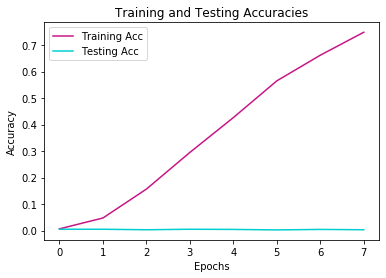

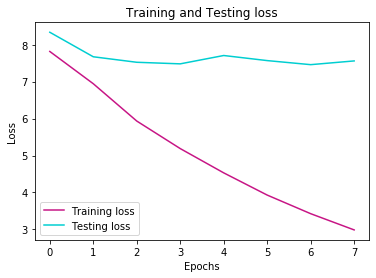

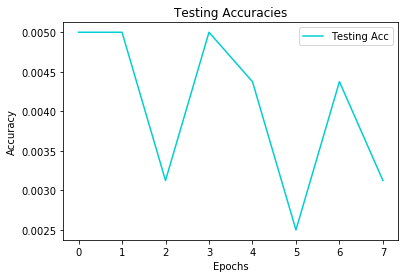

----- EPOCH ------- 
 9
Epoch [9/20], Batch [10/102], Loss: 2.5129, Accuracy: 0.8466
Epoch [9/20], Batch [20/102], Loss: 2.6722, Accuracy: 0.8140
Epoch [9/20], Batch [30/102], Loss: 2.7606, Accuracy: 0.8125
Epoch [9/20], Batch [40/102], Loss: 2.5061, Accuracy: 0.8133
Epoch [9/20], Batch [50/102], Loss: 3.0970, Accuracy: 0.8131
Epoch [9/20], Batch [60/102], Loss: 2.4626, Accuracy: 0.8115
Epoch [9/20], Batch [70/102], Loss: 2.3061, Accuracy: 0.8138
Epoch [9/20], Batch [80/102], Loss: 2.4778, Accuracy: 0.8094
Epoch [9/20], Batch [90/102], Loss: 3.1475, Accuracy: 0.8019
Epoch [9/20], Batch [100/102], Loss: 2.6440, Accuracy: 0.7970
Epoch [9/20], Batch [40/50], Loss: 7.9854, Accuracy: 0.0061
Training Loss:  2.6098655041526344
Training Accuracy:  0.7965686274509803
Train losses:
[7.816964560864019, 6.943717133765127, 5.933524309420118, 5.188007331361957, 4.530749536028095, 3.929521492883271, 3.4258010457543766, 2.9864241025027107, 2.6098655041526344]
Test losses:
[8.337122564315797, 7.6731729

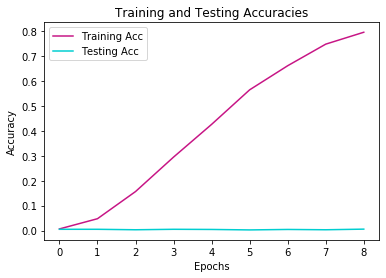

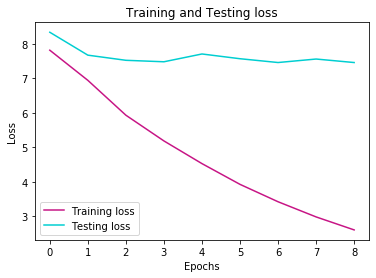

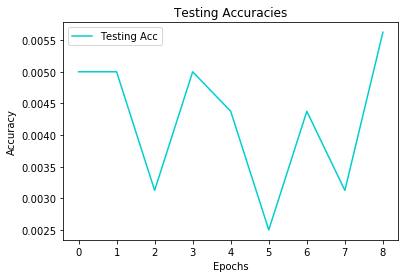

----- EPOCH ------- 
 10
Epoch [10/20], Batch [10/102], Loss: 2.3705, Accuracy: 0.8409
Epoch [10/20], Batch [20/102], Loss: 2.1133, Accuracy: 0.8557
Epoch [10/20], Batch [30/102], Loss: 2.2486, Accuracy: 0.8558
Epoch [10/20], Batch [40/102], Loss: 2.3550, Accuracy: 0.8460
Epoch [10/20], Batch [50/102], Loss: 2.2912, Accuracy: 0.8413
Epoch [10/20], Batch [60/102], Loss: 2.3227, Accuracy: 0.8407
Epoch [10/20], Batch [70/102], Loss: 2.5440, Accuracy: 0.8393
Epoch [10/20], Batch [80/102], Loss: 2.1836, Accuracy: 0.8364
Epoch [10/20], Batch [90/102], Loss: 2.5983, Accuracy: 0.8334
Epoch [10/20], Batch [100/102], Loss: 2.3575, Accuracy: 0.8354
Epoch [10/20], Batch [40/50], Loss: 7.6353, Accuracy: 0.0046


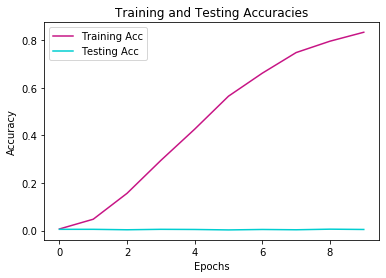

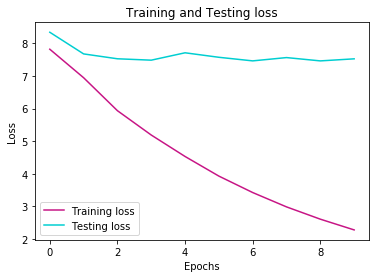

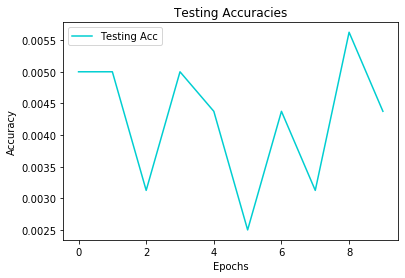

----- EPOCH ------- 
 11
Epoch [11/20], Batch [10/102], Loss: 2.0700, Accuracy: 0.9119
Epoch [11/20], Batch [20/102], Loss: 1.8864, Accuracy: 0.9033
Epoch [11/20], Batch [30/102], Loss: 1.8922, Accuracy: 0.9012
Epoch [11/20], Batch [40/102], Loss: 2.0817, Accuracy: 0.8925
Epoch [11/20], Batch [50/102], Loss: 2.0889, Accuracy: 0.8873
Epoch [11/20], Batch [60/102], Loss: 1.9106, Accuracy: 0.8858
Epoch [11/20], Batch [70/102], Loss: 1.9522, Accuracy: 0.8816
Epoch [11/20], Batch [80/102], Loss: 1.9045, Accuracy: 0.8808
Epoch [11/20], Batch [90/102], Loss: 2.1716, Accuracy: 0.8750
Epoch [11/20], Batch [100/102], Loss: 2.0357, Accuracy: 0.8744
Epoch [11/20], Batch [40/50], Loss: 7.6796, Accuracy: 0.0061


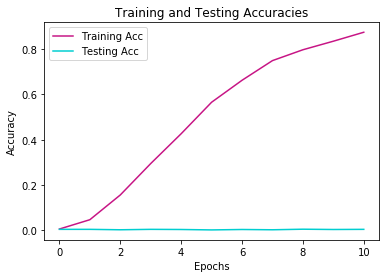

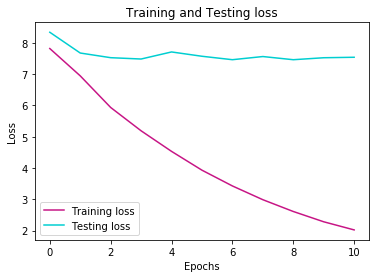

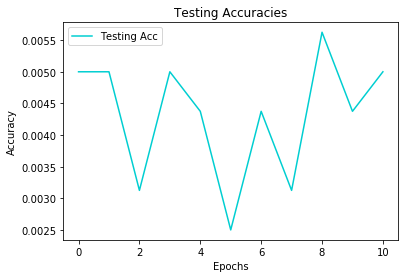

----- EPOCH ------- 
 12
Epoch [12/20], Batch [10/102], Loss: 1.8057, Accuracy: 0.9176
Epoch [12/20], Batch [20/102], Loss: 1.9083, Accuracy: 0.9077
Epoch [12/20], Batch [30/102], Loss: 1.8763, Accuracy: 0.9073
Epoch [12/20], Batch [40/102], Loss: 1.7821, Accuracy: 0.9070
Epoch [12/20], Batch [50/102], Loss: 1.8450, Accuracy: 0.9032
Epoch [12/20], Batch [60/102], Loss: 1.7586, Accuracy: 0.9006
Epoch [12/20], Batch [70/102], Loss: 2.0873, Accuracy: 0.8948
Epoch [12/20], Batch [80/102], Loss: 2.1009, Accuracy: 0.8951
Epoch [12/20], Batch [90/102], Loss: 2.0013, Accuracy: 0.8959
Epoch [12/20], Batch [100/102], Loss: 1.8221, Accuracy: 0.8936
Epoch [12/20], Batch [40/50], Loss: 7.5518, Accuracy: 0.0069


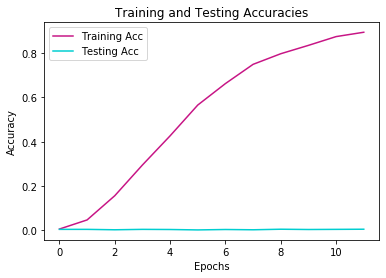

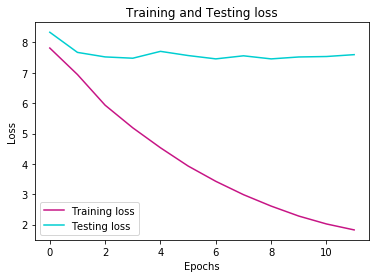

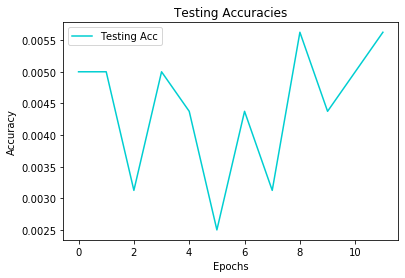

----- EPOCH ------- 
 13
Epoch [13/20], Batch [10/102], Loss: 1.2247, Accuracy: 0.9375
Epoch [13/20], Batch [20/102], Loss: 1.5142, Accuracy: 0.9360
Epoch [13/20], Batch [30/102], Loss: 1.7901, Accuracy: 0.9224
Epoch [13/20], Batch [40/102], Loss: 2.2929, Accuracy: 0.9162
Epoch [13/20], Batch [50/102], Loss: 1.7184, Accuracy: 0.9118
Epoch [13/20], Batch [60/102], Loss: 1.8049, Accuracy: 0.9062
Epoch [13/20], Batch [70/102], Loss: 1.5426, Accuracy: 0.9032
Epoch [13/20], Batch [80/102], Loss: 1.4737, Accuracy: 0.9039
Epoch [13/20], Batch [90/102], Loss: 1.9127, Accuracy: 0.8997
Epoch [13/20], Batch [100/102], Loss: 2.0451, Accuracy: 0.8985
Epoch [13/20], Batch [40/50], Loss: 7.4376, Accuracy: 0.0076
Training Loss:  1.687440498202455
Training Accuracy:  0.8970588235294118
Train losses:
[7.816964560864019, 6.943717133765127, 5.933524309420118, 5.188007331361957, 4.530749536028095, 3.929521492883271, 3.4258010457543766, 2.9864241025027107, 2.6098655041526344, 2.280921354013331, 2.0211378955

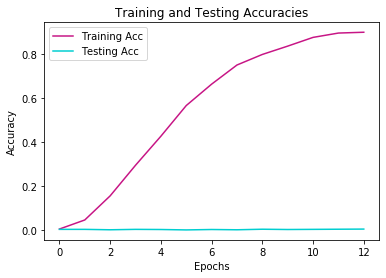

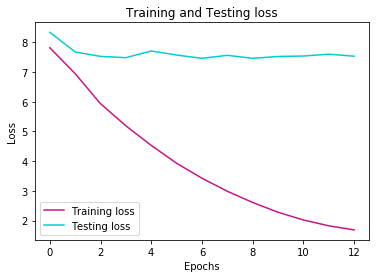

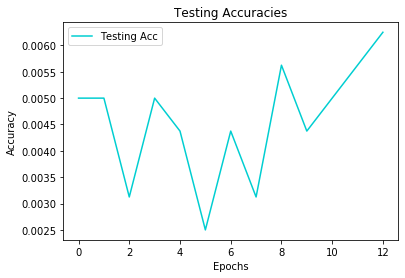

----- EPOCH ------- 
 14
Epoch [14/20], Batch [10/102], Loss: 1.4064, Accuracy: 0.9318
Epoch [14/20], Batch [20/102], Loss: 1.5550, Accuracy: 0.9182
Epoch [14/20], Batch [30/102], Loss: 1.6052, Accuracy: 0.9153
Epoch [14/20], Batch [40/102], Loss: 1.5371, Accuracy: 0.9207
Epoch [14/20], Batch [50/102], Loss: 1.4371, Accuracy: 0.9265
Epoch [14/20], Batch [60/102], Loss: 1.4265, Accuracy: 0.9237
Epoch [14/20], Batch [70/102], Loss: 1.4473, Accuracy: 0.9230
Epoch [14/20], Batch [80/102], Loss: 1.5839, Accuracy: 0.9228
Epoch [14/20], Batch [90/102], Loss: 1.4692, Accuracy: 0.9231
Epoch [14/20], Batch [100/102], Loss: 1.4568, Accuracy: 0.9192
Epoch [14/20], Batch [40/50], Loss: 7.4961, Accuracy: 0.0046


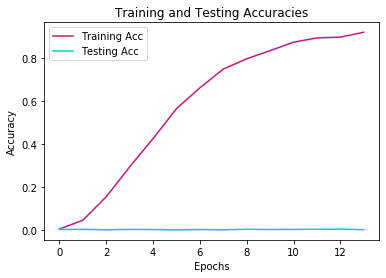

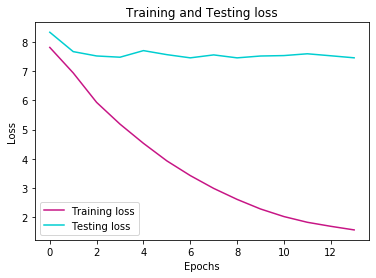

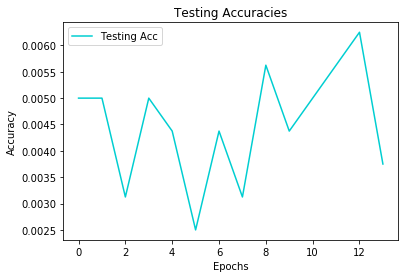

----- EPOCH ------- 
 15
Epoch [15/20], Batch [10/102], Loss: 1.4138, Accuracy: 0.9403
Epoch [15/20], Batch [20/102], Loss: 1.5089, Accuracy: 0.9226
Epoch [15/20], Batch [30/102], Loss: 1.3484, Accuracy: 0.9204
Epoch [15/20], Batch [40/102], Loss: 1.2922, Accuracy: 0.9230
Epoch [15/20], Batch [50/102], Loss: 1.3691, Accuracy: 0.9265
Epoch [15/20], Batch [60/102], Loss: 1.3276, Accuracy: 0.9267
Epoch [15/20], Batch [70/102], Loss: 1.2310, Accuracy: 0.9274
Epoch [15/20], Batch [80/102], Loss: 1.4365, Accuracy: 0.9267
Epoch [15/20], Batch [90/102], Loss: 1.8409, Accuracy: 0.9269
Epoch [15/20], Batch [100/102], Loss: 1.4860, Accuracy: 0.9254
Epoch [15/20], Batch [40/50], Loss: 7.2842, Accuracy: 0.0038


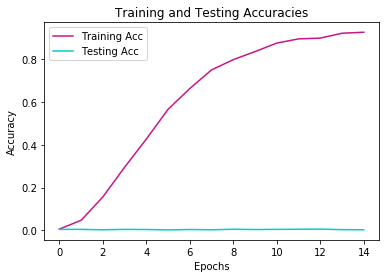

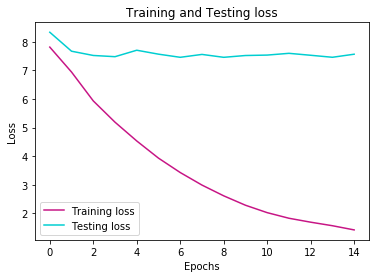

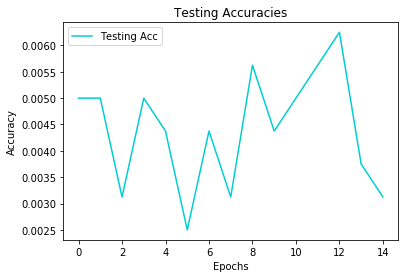

----- EPOCH ------- 
 16
Epoch [16/20], Batch [10/102], Loss: 1.3531, Accuracy: 0.9517
Epoch [16/20], Batch [20/102], Loss: 1.3191, Accuracy: 0.9420
Epoch [16/20], Batch [30/102], Loss: 1.3719, Accuracy: 0.9365
Epoch [16/20], Batch [40/102], Loss: 1.1814, Accuracy: 0.9383
Epoch [16/20], Batch [50/102], Loss: 1.3846, Accuracy: 0.9350
Epoch [16/20], Batch [60/102], Loss: 1.1332, Accuracy: 0.9375
Epoch [16/20], Batch [70/102], Loss: 1.3203, Accuracy: 0.9349
Epoch [16/20], Batch [80/102], Loss: 1.3419, Accuracy: 0.9317
Epoch [16/20], Batch [90/102], Loss: 1.8777, Accuracy: 0.9299
Epoch [16/20], Batch [100/102], Loss: 1.3531, Accuracy: 0.9307
Epoch [16/20], Batch [40/50], Loss: 7.7868, Accuracy: 0.0061


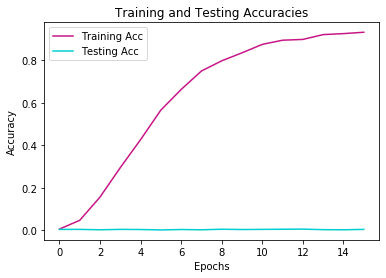

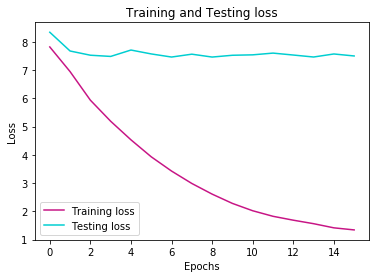

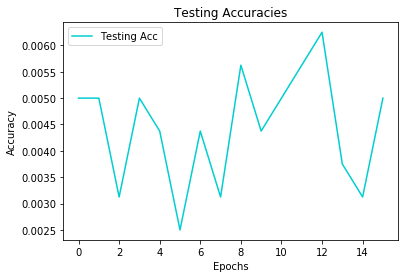

----- EPOCH ------- 
 17
Epoch [17/20], Batch [10/102], Loss: 0.9982, Accuracy: 0.9460
Epoch [17/20], Batch [20/102], Loss: 1.2675, Accuracy: 0.9360
Epoch [17/20], Batch [30/102], Loss: 1.3710, Accuracy: 0.9385
Epoch [17/20], Batch [40/102], Loss: 1.2391, Accuracy: 0.9367
Epoch [17/20], Batch [50/102], Loss: 1.2344, Accuracy: 0.9412
Epoch [17/20], Batch [60/102], Loss: 1.2732, Accuracy: 0.9401
Epoch [17/20], Batch [70/102], Loss: 1.2123, Accuracy: 0.9423
Epoch [17/20], Batch [80/102], Loss: 1.4192, Accuracy: 0.9417
Epoch [17/20], Batch [90/102], Loss: 1.3733, Accuracy: 0.9396
Epoch [17/20], Batch [100/102], Loss: 1.2363, Accuracy: 0.9390
Epoch [17/20], Batch [40/50], Loss: 7.7128, Accuracy: 0.0076
Training Loss:  1.2685683726095687
Training Accuracy:  0.9390318627450981
Train losses:
[7.816964560864019, 6.943717133765127, 5.933524309420118, 5.188007331361957, 4.530749536028095, 3.929521492883271, 3.4258010457543766, 2.9864241025027107, 2.6098655041526344, 2.280921354013331, 2.021137895

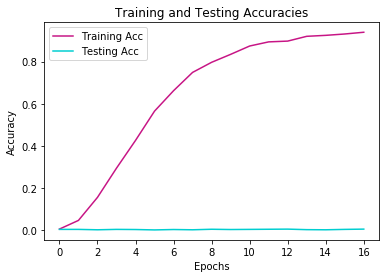

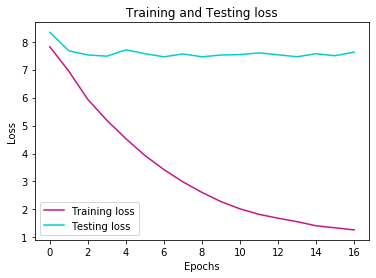

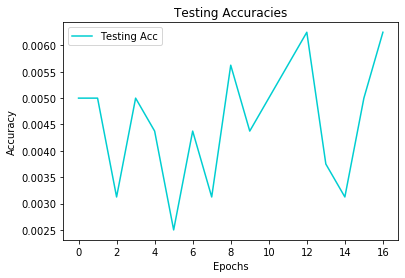

----- EPOCH ------- 
 18
Epoch [18/20], Batch [10/102], Loss: 0.9333, Accuracy: 0.9489
Epoch [18/20], Batch [20/102], Loss: 1.3782, Accuracy: 0.9583
Epoch [18/20], Batch [30/102], Loss: 1.1662, Accuracy: 0.9587
Epoch [18/20], Batch [40/102], Loss: 0.9623, Accuracy: 0.9543
Epoch [18/20], Batch [50/102], Loss: 1.0569, Accuracy: 0.9547
Epoch [18/20], Batch [60/102], Loss: 1.4210, Accuracy: 0.9513
Epoch [18/20], Batch [70/102], Loss: 1.3483, Accuracy: 0.9498
Epoch [18/20], Batch [80/102], Loss: 1.0948, Accuracy: 0.9514
Epoch [18/20], Batch [90/102], Loss: 1.1815, Accuracy: 0.9478
Epoch [18/20], Batch [100/102], Loss: 1.1571, Accuracy: 0.9462
Epoch [18/20], Batch [40/50], Loss: 7.5697, Accuracy: 0.0046


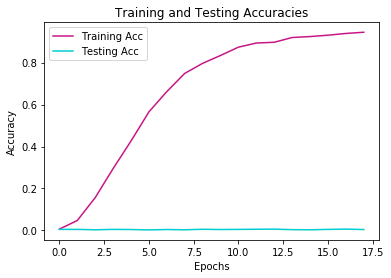

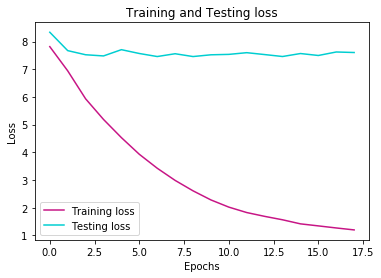

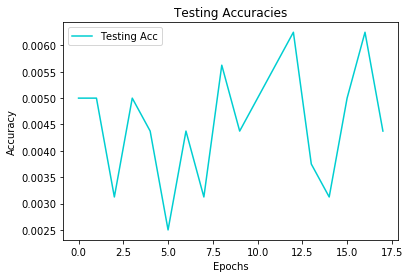

----- EPOCH ------- 
 19
Epoch [19/20], Batch [10/102], Loss: 1.3507, Accuracy: 0.9489
Epoch [19/20], Batch [20/102], Loss: 1.0161, Accuracy: 0.9479
Epoch [19/20], Batch [30/102], Loss: 1.0808, Accuracy: 0.9446
Epoch [19/20], Batch [40/102], Loss: 1.0166, Accuracy: 0.9436
Epoch [19/20], Batch [50/102], Loss: 0.9820, Accuracy: 0.9430
Epoch [19/20], Batch [60/102], Loss: 1.1829, Accuracy: 0.9442
Epoch [19/20], Batch [70/102], Loss: 1.0700, Accuracy: 0.9410
Epoch [19/20], Batch [80/102], Loss: 1.1449, Accuracy: 0.9398
Epoch [19/20], Batch [90/102], Loss: 1.2152, Accuracy: 0.9389
Epoch [19/20], Batch [100/102], Loss: 1.3341, Accuracy: 0.9375
Epoch [19/20], Batch [40/50], Loss: 7.5966, Accuracy: 0.0038


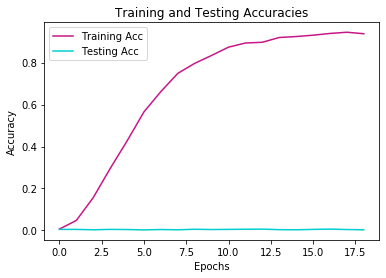

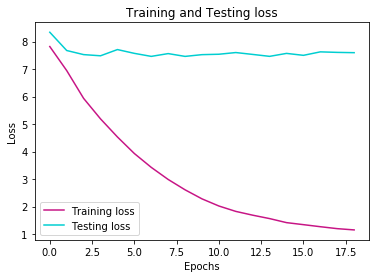

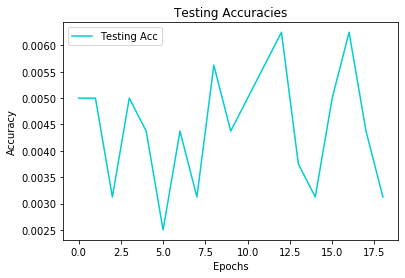

----- EPOCH ------- 
 20
Epoch [20/20], Batch [10/102], Loss: 1.1304, Accuracy: 0.9489
Epoch [20/20], Batch [20/102], Loss: 1.1560, Accuracy: 0.9554
Epoch [20/20], Batch [30/102], Loss: 1.1392, Accuracy: 0.9486
Epoch [20/20], Batch [40/102], Loss: 1.0699, Accuracy: 0.9474
Epoch [20/20], Batch [50/102], Loss: 1.2981, Accuracy: 0.9467
Epoch [20/20], Batch [60/102], Loss: 0.9111, Accuracy: 0.9462
Epoch [20/20], Batch [70/102], Loss: 1.2680, Accuracy: 0.9467
Epoch [20/20], Batch [80/102], Loss: 1.0322, Accuracy: 0.9468
Epoch [20/20], Batch [90/102], Loss: 1.0587, Accuracy: 0.9471
Epoch [20/20], Batch [100/102], Loss: 0.9387, Accuracy: 0.9455
Epoch [20/20], Batch [40/50], Loss: 7.6993, Accuracy: 0.0076


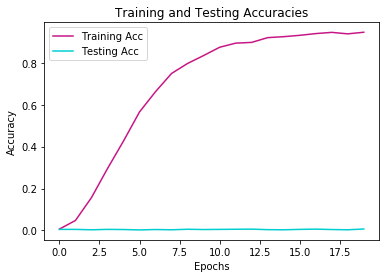

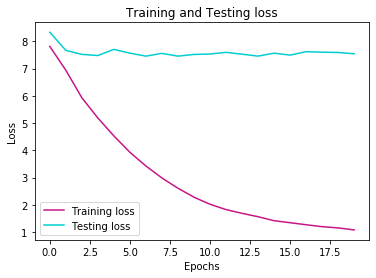

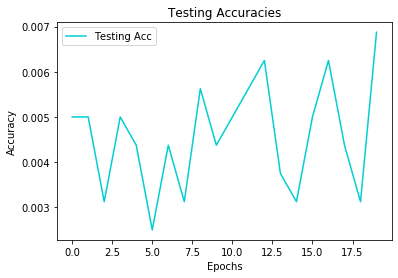

In [69]:
train_losses, test_losses, train_accs, test_accs = run_epochs(encoder, decoder, 
                                    optimizer, criterion, train_dataloader, val_dataloader, nepochs, run_id)

### Generating captions

In [70]:
def load_image(image_path, xform=None):
    image = Image.open(image_path)
    image = image.resize([64, 64], Image.LANCZOS)
    
    if xform is not None:
        image = xform(image).unsqueeze(0)
    
    return image

In [71]:
def word_ids2words(list_of_labels_ids):
    # Convert word_ids to words
    sampled_caption = []
    if not isinstance(list_of_labels_ids, list):
        list_of_labels_ids = [list_of_labels_ids]
    for word_id in list_of_labels_ids:
        word = VOCAB.idx2word[word_id]
        print("word: ", word)
        sampled_caption.append(word)
#         if word == '<end>':
#             break
    sentence = ' '.join(sampled_caption)
    return sentence

In [72]:
VOCAB.idx2word[1679]

'mindless'

In [73]:
def generate_caption_from_image(encoder, decoder, image_tensor):
    
    # Set model to eval
    encoder.eval()
    # Encode image
    feature = encoder(image_tensor)   
    decoder.eval()
    # Get captions
    sample_id = decoder.sample(feature)
    return sample_id.item()
    

In [74]:
def generate_labels(images):
    labels = []
    XFORMS = transforms.Compose([
        transforms.Resize((64, 64)),
        #transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
    
    # Load models 
#     encoder = EncoderCNN(64)
#     enc_load = './saved_models/encoder-19.pth'
#     dec_load = './saved_models/decoder-19.pth'
#     encoder.load_state_dict(torch.load(enc_load, map_location=DEVICE))
#     decoder.load_state_dict(torch.load(dec_load, map_location=DEVICE))
    
    for image_ in images:
        # Attach path to image
#         image_name = dataset_new_folder + "/" + dataset.train_data[1]
        print("\nimage: ", image_)
        image_name = dataset_new_folder + "/" + image_
#         print("image_name: ", image_name)
        # Load image and apply transformations
        image = load_image(image_name, XFORMS)
        
        # Move to proper device
        image_tensor = image.to(device)
        
        # Generate an caption from the image
        sampled_ids = generate_caption_from_image(encoder, decoder, image_tensor)
        
        # Decode ids to words
        caption = word_ids2words(sampled_ids)
        
        # Print out the image and the generated caption
        
        image = Image.open(image_name)
        plt.imshow(np.asarray(image))
        plt.show(image)
        # Print ground truth labels
        print("\nGround truth labels: ", dataset.labels[image_])
        print ("Generated labels: ", caption)


image:  a7d6c07e6cb3930096ebda922fff72f5d392ea2b.jpg
word:  local


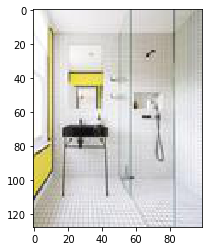


Ground truth labels:  ['generous']
Generated labels:  local

image:  ab76c255ebdc2c6b78f2ab2aabaa136a31bf167b.jpg
word:  sensual


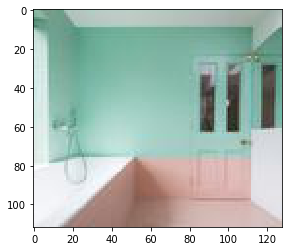


Ground truth labels:  ['generous']
Generated labels:  sensual

image:  2ecd7c1f54861ec8cfee73c6b6caca23418137a5.jpg
word:  impressed


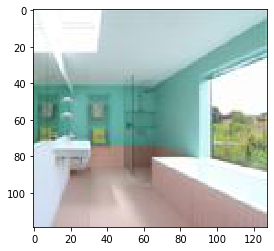


Ground truth labels:  ['generous']
Generated labels:  impressed

image:  e8aa5fac5a8b920f70dbaea631d5fadf3a658cb3.jpg
word:  inquisitive


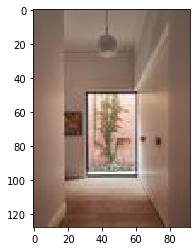


Ground truth labels:  ['secret']
Generated labels:  inquisitive

image:  7ce697ad5dbc2796ce1b86536e7e086646fa5540.jpg
word:  canadian


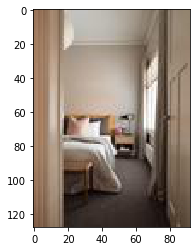


Ground truth labels:  ['secret']
Generated labels:  canadian

image:  78f53da4d212cd51d5f81246d3fa20e38a68d483.jpg
word:  due


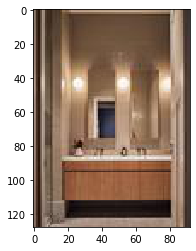


Ground truth labels:  ['secret']
Generated labels:  due

image:  52c8ef5e9138a1be21a6c0d8f4ee4b2f29d936d1.jpg
word:  many


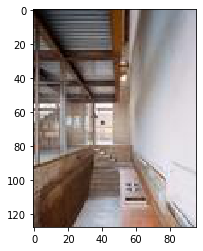


Ground truth labels:  ['independent']
Generated labels:  many

image:  13ce35a2564a372c558bd072b709315819c0308a.jpg
word:  ambitious


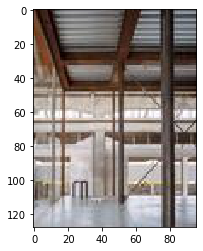


Ground truth labels:  ['independent']
Generated labels:  ambitious

image:  84af8434297e5ca1e39a7d87dd82669b58350d36.jpg
word:  imaginative


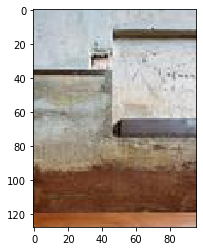


Ground truth labels:  ['independent']
Generated labels:  imaginative

image:  96f41c415f22ae0981d903f73fb914fc91972b0c.jpg
word:  capable


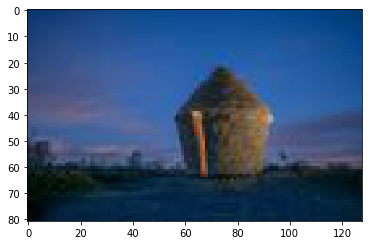


Ground truth labels:  ['material']
Generated labels:  capable

image:  13bfb62c3096f05d6c1a0c46608ca06ceedb5e56.jpg
word:  rightful


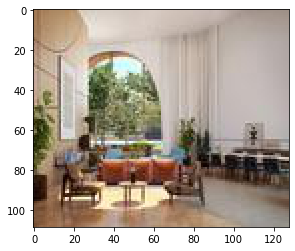


Ground truth labels:  ['vaulted']
Generated labels:  rightful

image:  e64ec8df798d6ddbc70e372afd3ed1d1d7ecaee4.jpg
word:  environmental


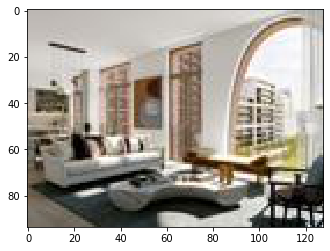


Ground truth labels:  ['vaulted']
Generated labels:  environmental

image:  822271aa06f965b873903bad6bfcafe76714b7e3.jpg
word:  concrete


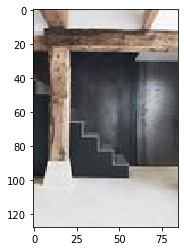


Ground truth labels:  ['indulgent']
Generated labels:  concrete

image:  653a3b7ad32a703be142560fb507280e97aefaa8.jpg
word:  oppositional


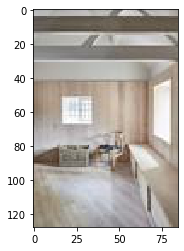


Ground truth labels:  ['indulgent']
Generated labels:  oppositional

image:  35157b8c2bfd86a5be7a72d5301f8d8b77e0187e.jpg
word:  great


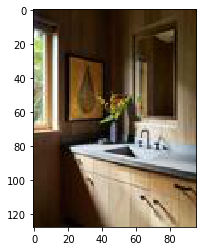


Ground truth labels:  ['steep']
Generated labels:  great

image:  cd2a42ab0645fc737ee9c3f169962648a48ba8f8.jpg
word:  simple


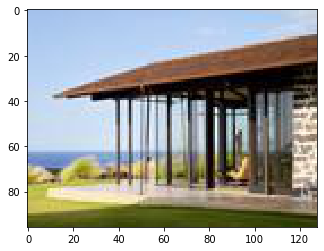


Ground truth labels:  ['steep']
Generated labels:  simple

image:  c5c92c3c52c73376abfab53225f93e9ba3bfafdd.jpg
word:  sloped


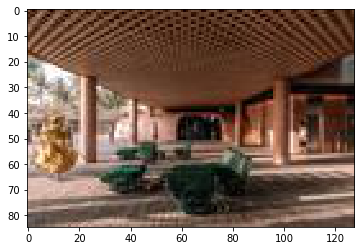


Ground truth labels:  ['balinese']
Generated labels:  sloped

image:  958e5e6c8e85e673bf904252c5e29bc3f1d8dfa1.jpg
word:  radiant


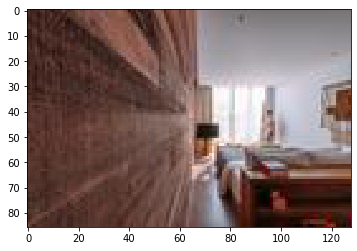


Ground truth labels:  ['balinese']
Generated labels:  radiant

image:  cec2ec06bec77c11184eda7c1cd8a46f6e643251.jpg
word:  toxic


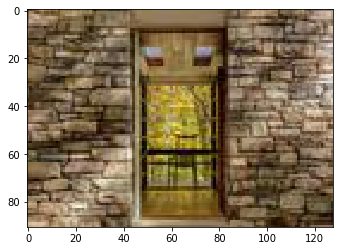


Ground truth labels:  ['extraordinary']
Generated labels:  toxic

image:  56f341f53b7ef5f077a8b233ffc8d2c0da945670.jpg
word:  mayan


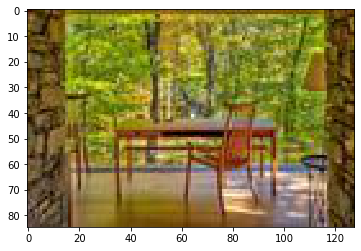


Ground truth labels:  ['extraordinary']
Generated labels:  mayan

image:  2db18cc32ccdb1e8a14d87d588a1dc25ecba8e5f.jpg
word:  wavy


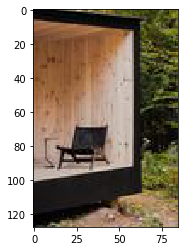


Ground truth labels:  ['introverted']
Generated labels:  wavy

image:  077f50e219c1e0f43922321fc13e2d3a11082795.jpg
word:  intriguing


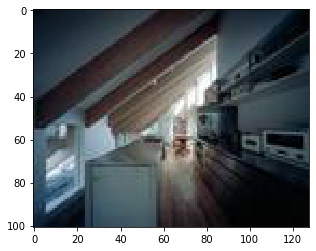


Ground truth labels:  ['gradual']
Generated labels:  intriguing

image:  20c6617668b12bd40d00e15c79167b97e9f78a8a.jpg
word:  local


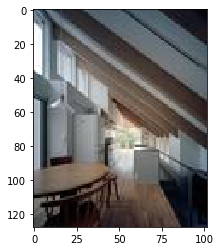


Ground truth labels:  ['gradual']
Generated labels:  local

image:  5be391420b1f5a04a5c5ca6ec39a1af607b7209f.jpg
word:  intriguing


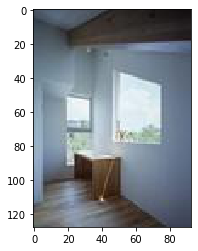


Ground truth labels:  ['gradual']
Generated labels:  intriguing

image:  83b96b3972a750ba4b0b587a8456d122f669d342.jpg
word:  imaginary


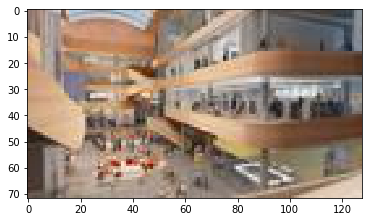


Ground truth labels:  ['curvilinear']
Generated labels:  imaginary

image:  d1a308c47f4073731a99ccc869b5ac7117901896.jpg
word:  sloped


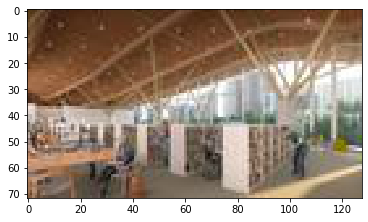


Ground truth labels:  ['curvilinear']
Generated labels:  sloped

image:  fc5ce7ff4e2f28d5defc491c6541b4271ab18b5e.jpg
word:  open


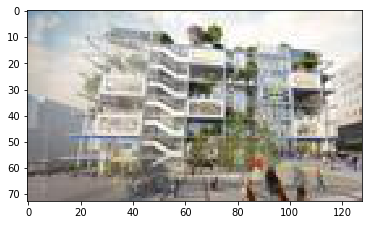


Ground truth labels:  ['short']
Generated labels:  open

image:  ea38970b5e1e2af0a7fe99489f7f407ab957fd7a.jpg
word:  eco


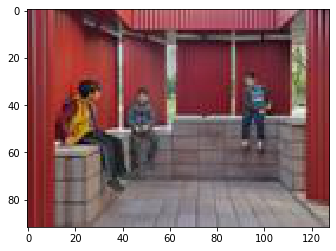


Ground truth labels:  ['cheap']
Generated labels:  eco

image:  a5b032c4e0f892cdec0c7503890bf8adb53dcad7.jpg
word:  balinese


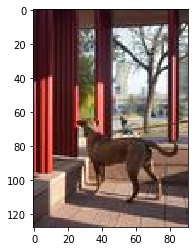


Ground truth labels:  ['cheap']
Generated labels:  balinese

image:  eeb3cdd0dab50e10e8dbcb027ee964718d899aaa.jpg
word:  sustainable


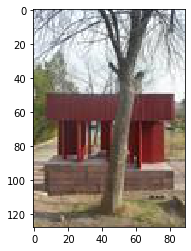


Ground truth labels:  ['cheap']
Generated labels:  sustainable

image:  6f1920cd29d2937e6e848db33acebef5abf7b929.jpg
word:  collaborative


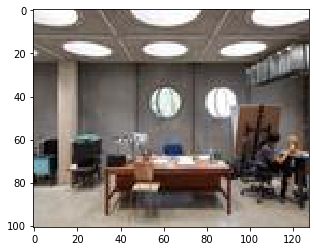


Ground truth labels:  ['fashioned']
Generated labels:  collaborative

image:  679821c3f2b91cc4c6fbba7bd5afaa23fda46a0c.jpg
word:  tectonic


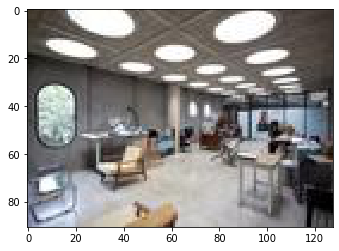


Ground truth labels:  ['fashioned']
Generated labels:  tectonic

image:  389de64b2d0d461cb827ad0c4eff80e2567a8249.jpg
word:  understated


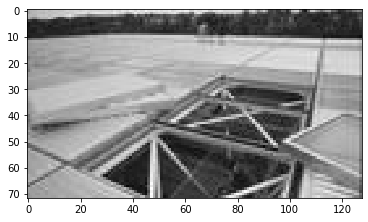


Ground truth labels:  ['portal']
Generated labels:  understated

image:  04307420f35a99678c3f773783133969332ab931.jpg
word:  many


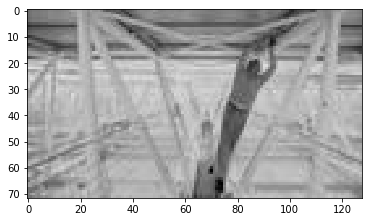


Ground truth labels:  ['portal']
Generated labels:  many

image:  3bd56ec19e7e0880090d7cc0c8e3a930c90b9a95.jpg
word:  same


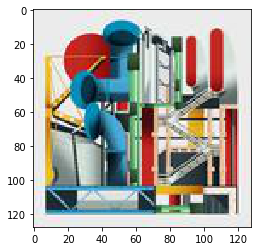


Ground truth labels:  ['portal']
Generated labels:  same

image:  7ab4e6e9a461d2c2442f3464464fcaafd9563ad2.jpg
word:  ambitious


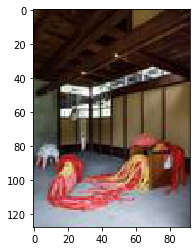


Ground truth labels:  ['material']
Generated labels:  ambitious

image:  5d14ace4116c8ee87b122d3cb30f1144a2703dc6.jpg
word:  unjust


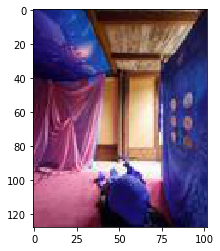


Ground truth labels:  ['material']
Generated labels:  unjust

image:  b479d1ab200aca3e3b50311aa4217e064d0cd59e.jpg
word:  live


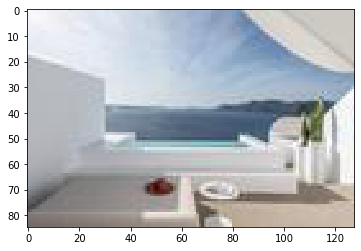


Ground truth labels:  ['synthetic']
Generated labels:  live

image:  d5b3fab18d9ec22a42147bdb981a9c6d1140dde9.jpg
word:  high


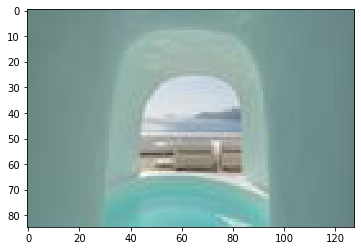


Ground truth labels:  ['synthetic']
Generated labels:  high

image:  9dd864d4e14082eb029d4fe9c7f3a2bfb2a8e630.jpg
word:  great


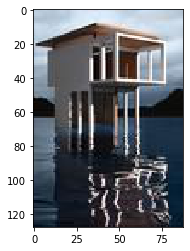


Ground truth labels:  ['social']
Generated labels:  great

image:  2e6b7236a83e6d5fe79bb4dbf4578b1f4fddbff0.jpg
word:  trivial


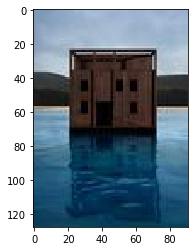


Ground truth labels:  ['social']
Generated labels:  trivial

image:  73116afcfa1fc710c39216f4a12e3cb0a934d056.jpg
word:  micro


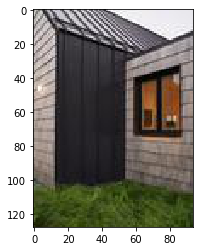


Ground truth labels:  ['rustic']
Generated labels:  micro

image:  2b0583f92180e49d8f877faecbd71ffa198fa551.jpg
word:  edgy


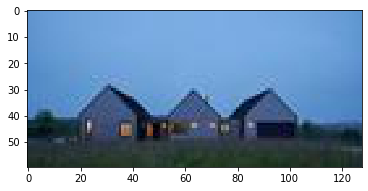


Ground truth labels:  ['rustic']
Generated labels:  edgy

image:  480010b43852202dc13fd37cf7a323c8046e4516.jpg
word:  direct


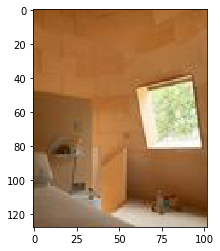


Ground truth labels:  ['agricultural']
Generated labels:  direct

image:  4f10922ee1f2c20b81af72e26819eee4f382d04b.jpg
word:  balinese


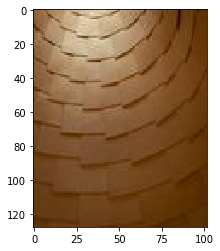


Ground truth labels:  ['agricultural']
Generated labels:  balinese

image:  b587fe3dc7d2c15ec178e9364c6ff2baec301888.jpg
word:  balinese


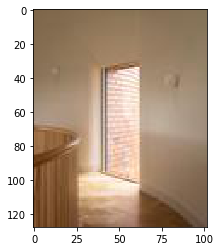


Ground truth labels:  ['agricultural']
Generated labels:  balinese

image:  ccb91162868cd9d2e484e61a23fef56ecf49e6e8.jpg
word:  gridded


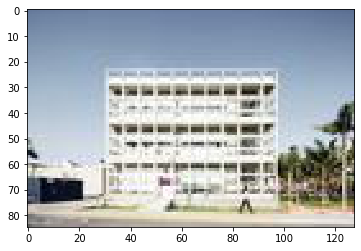


Ground truth labels:  ['maximum']
Generated labels:  gridded

image:  388ba9b2c880b1fe5a33a43a07e8c72768e18fa4.jpg
word:  similar


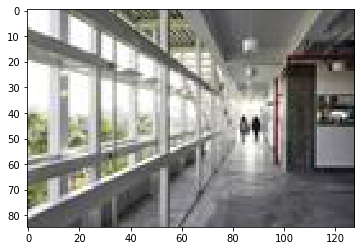


Ground truth labels:  ['maximum']
Generated labels:  similar

image:  14fdec41d2851a20d1b282934e531b26bf9fb16e.jpg
word:  great


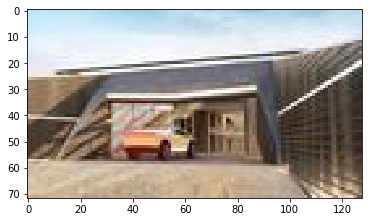


Ground truth labels:  ['armoured']
Generated labels:  great

image:  636903cf5deb437b381db8a237833671ec436b75.jpg
word:  recessed


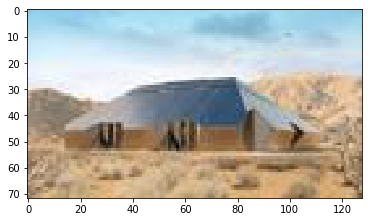


Ground truth labels:  ['armoured']
Generated labels:  recessed


In [75]:
generate_labels(dataset.val_d[0:50])

In [ ]:
from ctcdecode import CTCBeamDecoder
from Levenshtein import distance as levenshtein_distance

In [ ]:
name =  dataset.train_data[1]

In [ ]:
dataset.labels[name]